* By: Illya Barziy
* Email: illyabarziy@gmail.com
* Reference: __Estimation of Theory-Implied Correlation__ _by_ Marcos Lopez de Prado

# The Theory-Implied Correlation Algorithm (TIC)

This description of the algorithm and the realizations in the mlfinlab package are based on the paper by _Marcos Lopez de Prado_ __Estimation of Theory-Implied Correlation Matrices__  [available here](https://papers.ssrn.com/sol3/abstract_id=3484152). Quotation marks are used in the descriptions below to indicate direct quotes from the paper.

The Correlation Matrix Distance metric is described in a paper by _Markus Herdin_ and _Ernst Bonek_ __AMIMO Correlation Matrix based Metric for Characterizing Non-Stationarity__ [available here](https://publik.tuwien.ac.at/files/pub-et_8791.pdf).



## Introduction

In finance, the correlation matrices are widely used in portfolio management and a variety of other tasks. As they are calculated based on the series of historical observations, they pose the following caveats:
- "Empirical correlation matrices have poor numerical properties and as a result, unreliable estimators". Some of the examples of these problems are described in the NCO notebook [available here](https://github.com/hudson-and-thames/research/blob/master/NCO/NCO.ipynb)
- "Empirical correlation matrices have poor predictive power".

There are also factor-based correlation matrices, that have the following caveats:
- "Factor-based correlation matrices are typically non-hierarchical. And instruments are usually exhibiting a nested cluster structure".

The TIC algorithm estimates the forward-looking correlation matrix implied by a proposed hierarchical structure of the assets. This hierarchical structure can be implied from economic theory or alternative classification methods. 

### Motivation

"The numerical problems [of the empirical correlation matrices] have traditionally  been  addressed  by  shrinking  the  correlation matrix  (in a work by _Ledoit_  and _Wolf_ [available here](http://perso.ens-lyon.fr/patrick.flandrin/LedoitWolf_JMA2004.pdf))". 

"Shrinkage eliminates some of the noise in the correlation matrix, at the cost of diluting much of the signal. A better approach is to shrink only the eigenvalues associated with noise (in the works by _Potter et al._ [available here](https://arxiv.org/abs/physics/0507111), and by _Lopez de Prado_ [available here](https://www.cambridge.org/core/books/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545))".

Another problem that requires a solution is the lack of the user-defined structure of the correlation matrices. This would add "forward-looking views of the world (in contrast to the backward-looking views of empirical correlations)".

"Academics  and  practitioners  often  work  with  factor-based  correlation matrices,  where  the economic factors impose a theoretical structure. Factor-based correlation matrices pose problems of their own: 
 - (a) the factors are not robustly estimated, because they are derived from empirical correlation  matrices,  subject  to  the  same  numerical  ill-conditioning;  
 - (b)  the  factors  do  not represent  forward-looking  views,  because  they  are  estimated  from  historical  series;
 - (c) factor-based  correlation matrices  are  derived  from  structural  regression  models  that fail  to recognize  the  complex  hierarchical  interactions  among  securities."

An example of a hierarchical structure for the financial instruments is the __MSCI’s Global Industry  Classification  Standard  (GICS)__ [(link)](https://www.msci.com/gics) that classifies investment  universes  in  terms  of four nested levels.

### Input data

The algorithm combines empirical data - the correlation matrix of the assets with the fundamental structure provided by the economic theory - the hierarchical structure of the assets.

"This  departure of the theory-implied  correlation  matrix from the empirical correlation matrix  can  be  justified  in  terms  of:  
- The  need  to  correct  for  spurious correlations,  driven  by  noise  rather  than  signal; 
- The  desire  to  make  a  forward-looking statement, rather than the backward-looking views expressed by historical correlations."

### Tree graph

The tree graph, representing the economic theory and the hierarchical structure of the assets "can have as many  levels  as  needed,  with  one  or  more leaves  per  branch,  and  some  branches  may  include more  levels  than  other  branches".

The assets may be also grouped according to structures of other nature than those of economic theory, such as knowledge graphs (from the work of _Liu et al._ [available here](https://link.springer.com/chapter/10.1007/978-3-319-97289-3_8)), that are build based on the position of the companies to others in terms of business ties, competitors etc. based on the data extracted from the news articles.

"The columns [in a tree graph] are ordered bottom-up, with the leftmost column corresponding to the terminal leaves, and the rightmost column corresponding to the tree's root".

A tree graph based on the GICS to use in the algorithm may look as follows:


| Ticker        | Sub-Industry   | Industry  | Industry Group  | Sector  |
|---------------|----------------|-----------|-----------------|---------|
| A UN Equity   | 35203010       | 352030    | 3520            | 35      |
| AAL UW Equity | 20302010       | 203020    | 2030            | 20      |
| AAP UN Equity | 25504050       | 255040    | 2550            | 25      |
| AAPL UW Equity| 45202030       | 452020    | 4520            | 45      |

### Empirical correlation matrix

The correlation matrix, representing the empirical data is estimated based on historical observations.

"This empirical correlation matrix must be symmetric, and include a main diagonal of 1s. However, the empirical correlation matrix does not need to be invertible, positive definite  or  non-singular."

A correlation matrix based on historical data to use in the algorithm may look as follows:


| Ticker            | A UN Equity | AAL UW Equity | AAP UN Equity | AAPL UW Equity |
|-------------------|-------------|---------------|---------------|----------------|
| **A UN Equity**   | 1           | 0.73          | 0.65          | 0.77           |
| **AAL UW Equity** | 0.73        | 1             | 0.82          | 0.75           |
| **AAP UN Equity** | 0.65        | 0.82          | 1             | 0.59           |
| **AAPL UW Equity**| 0.77        | 0.75          | 0.59          | 1              |

## The TIC Algorithm
The TIC algorithm consists of three steps:
1. Fitting our tree graph structure based on the empirical correlation matrix
2. Deriving our correlation matrix from the linkage object
3. De-noising our correlation matrix

### Fitting our Tree Graph Structure
__In the first step, the theoretical tree graph structure of the assets is fit on the evidence presented by the empirical correlation matrix.__

 - If there is no top level of the tree (tree root), this level is added so that all variables are included in one general cluster.

 - The empirical correlation matrix is transformed into a matrix of distances using the above formula:

    $$d_{i,j} = \sqrt{\frac{1}{2}(1 - \rho{i,j})}$$

 - For each level of the tree, the elements are grouped by elements from the higher level. The algorithm iterates from the lowest to the highest level of the tree.

 - A linkage object is created for these grouped elements based on their distance matrix using the [SciPy linkage function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). Each link in the linkage object is an array representing a cluster of two elements and has the following data as elements:
    - ID of the first element in a cluster

    - ID of the second element in a cluster

    - Distance between the elements

    - Number of atoms (simple elements from the portfolio and not clusters) inside

 - A linkage object is transformed to reflect the previously created clusters.

 - A transformed local linkage object is added to the global linkage object

 - Distance matrix is adjusted to the newly created clusters - elements that are now in the new clusters are replaced by the clusters in the distance matrix. The distance from the new clusters to the rest of the elements in the distance matrix is calculated as a weighted average of distances of two elements in a cluster to the other elements. The weight is the number of atoms in an element. So, the formula is:

$$DistanceCluster = \frac{Distance_1 * NumAtoms_1 + Distance_2 * NumAtoms_2}{NumAtoms_1 + NumAtoms_2}$$

 - The linkage object, representing a dendrogram of all elements in a portfolio is the result of the first step of the algorithm. It sequentially clusters two elements together, while measuring how closely together the two elements are, until all elements are subsumed within the same cluster.

"Note that the dendrogram  is  not the  tree  graph.  The  tree  graph  could  have  one  or  more  leaves  per  branch, whereas  the  dendrogram  always  has  two  items  per  cluster.  The  tree  graph  could  have  an unlimited number of levels, whereas the dendrogram always has $N-1$ clusters. The tree graph did not incorporate a notion of distance, whereas the dendrogram does."

### Deriving our Correlation Matrix
__In the second step, a correlation matrix is derived from the linkage object.__

 - One by one, the clusters (each represented by a link in the linkage object) are decomposed to lists of atoms contained in each of the two elements of the cluster.

 - The elements on the main diagonal of the resulting correlation matrix are set to 1s. The off-diagonal correlations between the variables are computed as:

$$\rho_{i,j} = 1 - 2 * d_{i,j}^{2}$$

### De-Noising our Correlation Matrix
__In the third step, the correlation matrix is de-noised.__

- The eigenvalues and eigenvectors of the correlation matrix are calculated.

- Marcenko-Pastur distribution is fit to the eigenvalues of the correlation matrix and the maximum theoretical eigenvalue is calculated.

- This maximum theoretical eigenvalue is set as a threshold and all the eigenvalues above the threshold are shrinked.

- The de-noised correlation matrix is calculated back from the eigenvectors and the new eigenvalues.

The algorithm for de-noising the correlation and the covariance matrix is implemented in the RiskEstimators class of the mlfinlab package. It is described in more detail [here](https://github.com/hudson-and-thames/research/blob/master/RiskEstimators/RiskEstimators.ipynb)

__Note:__

"If all variables depend directly from a single category, then the theory-implied correlation matrix will be the same as the empirical correlation matrix. That does not mean that the more structure is  imposed  by  the  economic  theory,  the  more  the  theory-implied  correlation  matrix  will  depart from the empirical correlation matrix. The degree of departure will depend on how much the tree graph forces the clustering of variables that the empirical correlation deems distant."

## Usage of the Algorithm

Let's use the TIC algorithm on the set of ETFs. 

We will use the series of daily prices of the ETFs. We also need to determine the classification to use for the data. We will propose the classification of the ETFs similar to that of GICS. 

In [1]:
import mlfinlab as ml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Getting the price data for ETFs
etf_prices = pd.read_csv('../../Sample-Data/stock_prices.csv', parse_dates=True, index_col='Date')

# We need to calculate the series of returns from a series of prices to calculate the correlation matrix

# Class with returns calculation function
ret_est = ml.portfolio_optimization.ReturnsEstimators()

# Calculating returns
etf_returns = ret_est.calculate_returns(etf_prices)

# Having a look at the result that we've obtained
etf_returns.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-03,0.008997,-0.002826,0.003376,0.003779,0.001662,0.002054,-0.000527,0.006281,0.018160,0.011824,...,-0.001426,0.002345,-0.006847,0.003623,0.002823,-0.000483,-0.001377,0.001293,0.001183,0.000842
2008-01-04,-0.030037,-0.019552,-0.000280,-0.025602,-0.022719,0.002619,-0.024525,-0.023720,-0.030202,-0.036549,...,0.007614,-0.028139,-0.019125,-0.024332,-0.025630,-0.024506,0.000212,0.001162,0.001281,-0.019657
2008-01-07,0.007327,0.000867,-0.000187,-0.006182,0.001045,0.001817,0.007299,0.002984,-0.013732,-0.003871,...,0.020779,0.011368,0.028971,-0.000411,-0.001824,-0.000849,0.004349,0.000258,0.000689,-0.000858
2008-01-08,-0.007754,-0.006930,0.000748,-0.002333,-0.005610,0.002154,-0.007783,-0.014025,-0.015415,-0.017487,...,0.000231,-0.016860,-0.014078,-0.007539,-0.004417,-0.016148,-0.001162,0.001031,0.000197,-0.017258
2008-01-09,0.032780,0.003199,-0.000747,0.021824,0.007216,-0.001584,0.002975,0.000431,0.006313,0.013184,...,0.010870,0.019435,0.062779,0.001381,0.021267,0.010510,0.001903,-0.001159,-0.000885,0.008820


In [5]:
# Now the empirical correlation matrix can be calculated
etf_corr = etf_returns.corr()

# Getting the tree graph for ETFs
etf_tree = pd.read_csv('../../Sample-Data/classification_tree.csv')

# Having a look at the tree structure of ETFs
etf_tree

,TICKER,SECTOR,REGION,TYPE
0,EEM,101010,1010,10
1,EWG,102010,1020,10
2,TIP,203010,2030,20
3,EWJ,104010,1040,10
4,EFA,103010,1030,10
5,IEF,203010,2030,20
6,EWQ,102010,1020,10
7,EWU,102010,1020,10
8,XLB,103020,1030,10
9,XLE,103030,1030,10


A proposed tree structure for ETFs has four levels:

1. Type of the ETF
 - 10 - Equity ETF
 - 20 - Bond ETF
2. Region of the ETF
 - XX10 - Emerging markets
 - XX20 - Europe
 - XX30 - US and Canada
 - XX40 - Asia
3. Sector of the ETF
 - XXXX10 - General/No sector
 - XXXX20 - Materials
 - XXXX30 - Energy
 - XXXX40 - Financial
 - XXXX50 - Technology
 - XXXX60 - Utilities
4. Ticker of the ETF

Now we can use the algorithm to calculate the theory-implied correlation matrix.

In [6]:
# Calculating the relation of sample length T to the number of variables N
# It's used for de-noising the TIC matrix
tn_relation = etf_returns.shape[0] / etf_returns.shape[1]

# Class with TIC function
tic = ml.portfolio_optimization.TIC()

# Calculating theory-implied correlation matrix
etf_tic = tic.tic_correlation(etf_tree, etf_corr, tn_relation, kde_bwidth=0.01)

# Setting the indexes of the theory-implied correlation matrix
etf_tic = pd.DataFrame(etf_tic, index=etf_corr.index, columns=etf_corr.index)

We can visualize the difference between the Empirical correlation matrix and the Theory-implied correlation matrix using heatmaps.

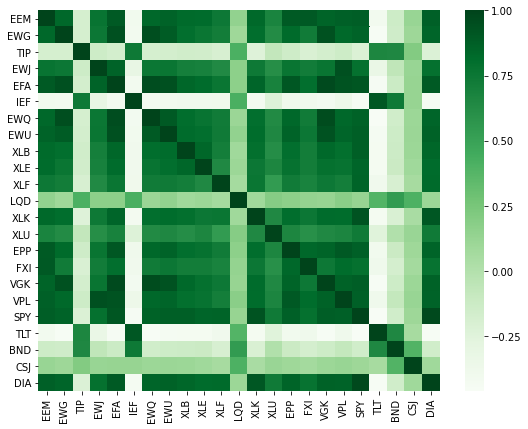

In [8]:
# Plotting the heatmap of the Empirical correlation matrix
plt.figure(figsize=(9,7))
sns.heatmap(etf_corr, cmap="Greens")
plt.show()

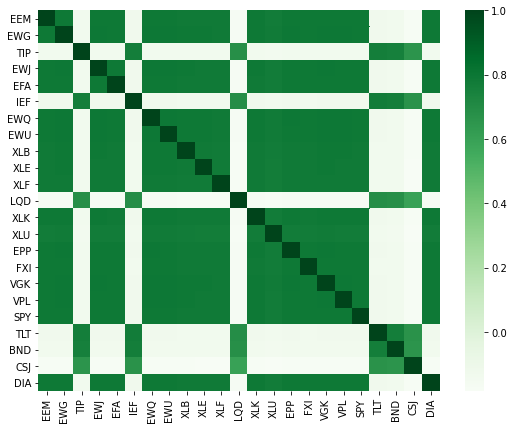

In [10]:
# Plotting the heatmap of the Theory-implied correlation matrix
plt.figure(figsize=(9,7))
sns.heatmap(etf_tic, cmap="Greens")
plt.show()

We can see that the Theory-implied correlation matrix is less noisy and has a clearly defined structure in comparison to the Empirical correlation matrix.

If we want to measure the similarity of the Empirical correlation matrix and the Theory-implied correlation matrix, we can use the correlation matrix distance introduced by _Herdin_ and _Bonek_ in a paper __AMIMO Correlation Matrix based Metric for Characterizing Non-Stationarity__ [available here](https://publik.tuwien.ac.at/files/pub-et_8791.pdf). The distance is calculated as:

$$d[\sum_{1},\sum_{2}] = 1 - \frac{tr(\sum_{1}\sum_{2})}{||\sum_{1}||_f||\sum_{2}||_f}$$

Where $\sum_{1},\sum_{2}$ are the two correlation matrices and the $||.||_f$ is the Frobenius norm.

"The distance $d[\sum_{1},\sum_{2}]$ measures the orthogonality between the considered correlation matrices. It becomes zero if the correlation matrices are equal up to a scaling factor, and one if they differ to a maximum extent".

In [11]:
# Calculating the correlation matrix distance
distance = tic.corr_dist(etf_corr, etf_tic)

# Printing the result
print('The distance between empirical and the theory-implied correlation matrices is' , distance)

The distance between empirical and the theory-implied correlation matrices is 0.035661302090136515


The correlation matrices are different but are not too far apart. This shows that the theory-implied correlation matrix blended theory-implied views with empirical ones.

## Conclusion

This notebook describes the Theory-Implied Correlation (TIC) algorithm and the correlation matrix distance metric. Also, it shows how these can be used on some real examples.

The algorithms and the descriptions were originally presented by _Marcos Lopez de Prado_ in the paper __Estimation of Theory-Implied Correlation Matrices__  [available here](https://papers.ssrn.com/sol3/abstract_id=3484152).

Key takeaways from the notebook:
- Empirical correlation matrices have poor numerical properties and predictive power.
- Correlation matrices lack the user-defined structure based on economic theory or alternative approaches.
- The TIC algorithm estimates the forward-looking correlation matrix implied by a proposed hierarchical structure of the assets. 
- The algorithm combines empirical data - the correlation matrix of the assets with the fundamental structure provided by the economic theory - the hierarchical structure of the assets.
- The tree graph used in the TIC algorithm can have as many levels as needed, with one or more leaves per branch, and some branches may include more levels than other branches.
- This empirical correlation matrix used in the TIC algorithm must be symmetric, and include a main diagonal of 1s. However, the empirical correlation matrix does not need to be invertible, positive definite or non-singular.
- The TIC algorithm consists of three steps:
  - In the first step, the theoretical tree graph structure of the assets is fit on the evidence presented by the empirical correlation matrix.
  - In the second step, a correlation matrix is derived from the linkage object.
  - In the third step, the correlation matrix is de-noised.
- The MSCI’s Global Industry Classification Standard (GICS) can be used to classify investment universes in terms of four nested levels.
- The similarity of the Empirical correlation matrix and the Theory-implied correlation matrix can be measured using the correlation matrix distance introduced by Herdin and Bonek.